# MCMC sampling diagnostics

In this notebook, we illustrate how to assess the quality of your MCMC samples, e.g. convergence and auto-correlation, in pyPESTO.

## The pipeline

First, we load the model and data to generate the MCMC samples from. In this example we show a toy example of a conversion reaction, loaded as a [PEtab](https://github.com/petab-dev/petab) problem.

In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize

import petab
import numpy as np
import logging
import matplotlib.pyplot as plt

# log diagnostics
logger = logging.getLogger("pypesto.sample.diagnostics")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

# import to petab
petab_problem = petab.Problem.from_yaml(
    "conversion_reaction/conversion_reaction.yaml")
# import to pypesto
importer = pypesto.petab.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

Create the sampler object, in this case we will use adaptive parallel tempering with 3 temperatures.

In [2]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(),
    n_chains=3)

First, we will initiate the MCMC chain at a "random" point in parameter space, e.g. $\theta_{start} = [3, -4]$

In [3]:
result = sample.sample(problem, n_samples=10000, sampler=sampler, x0=np.array([3,-4]))
elapsed_time = result.sample_result.time
print(f'Elapsed time: {round(elapsed_time,2)}')

100%|██████████| 10000/10000 [01:11<00:00, 139.52it/s]

Elapsed time: 90.35


Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., 'pypesto.sample.geweke_test'.


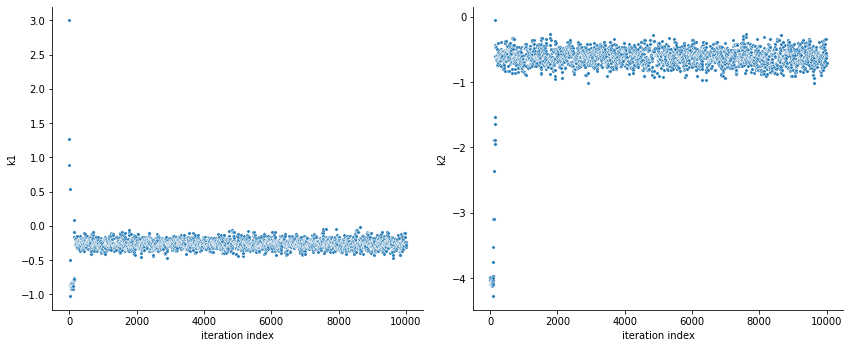

In [4]:
ax = visualize.sampling_parameters_trace(result, use_problem_bounds=False, size=(12,5))

By visualizing the chains, we can see a warm up phase occurring until convergence of the chain is reached. This is commonly known as "burn in" phase and should be discarded. An automatic way to evaluate and find the index of the chain in which the warm up is finished can be done by using the Geweke test.

Geweke burn-in index: 500


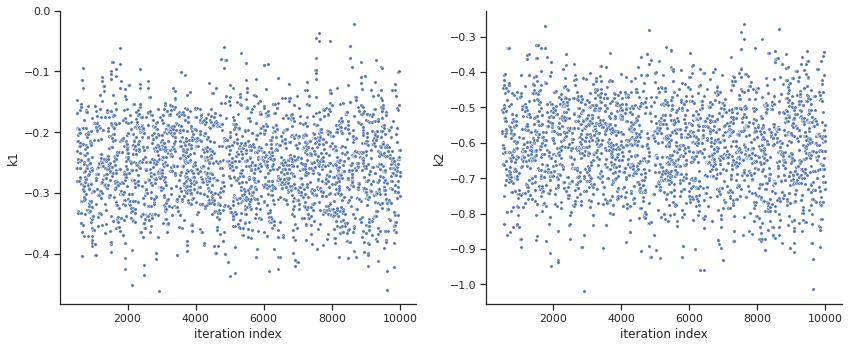

In [5]:
sample.geweke_test(result=result)
ax = visualize.sampling_parameters_trace(result, use_problem_bounds=False, size=(12,5))

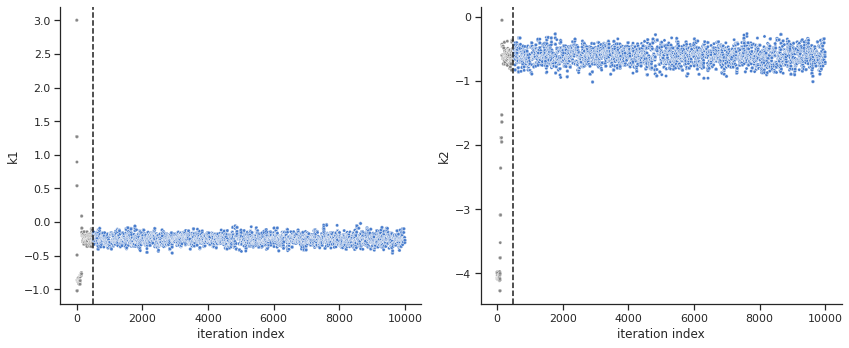

In [6]:
ax = visualize.sampling_parameters_trace(result, use_problem_bounds=False, full_trace=True, size=(12,5))

Calculate the effective sample size per computation time. We save the results in a variable as we will compare them later.

In [7]:
sample.effective_sample_size(result=result)
ess = result.sample_result.effective_sample_size
print(f'Effective sample size per computation time: {round(ess/elapsed_time,2)}')

Estimated chain autocorrelation: 8.854376880775783
Estimated effective sample size: 964.1401090042374


Effective sample size per computation time: 10.67


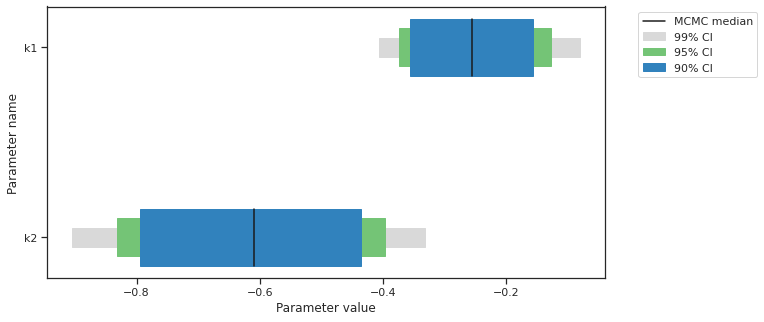

In [8]:
alpha = [99, 95, 90]
ax = visualize.sampling_parameters_cis(result, alpha=alpha, size=(10,5))

100%|██████████| 1901/1901 [00:05<00:00, 355.94it/s]


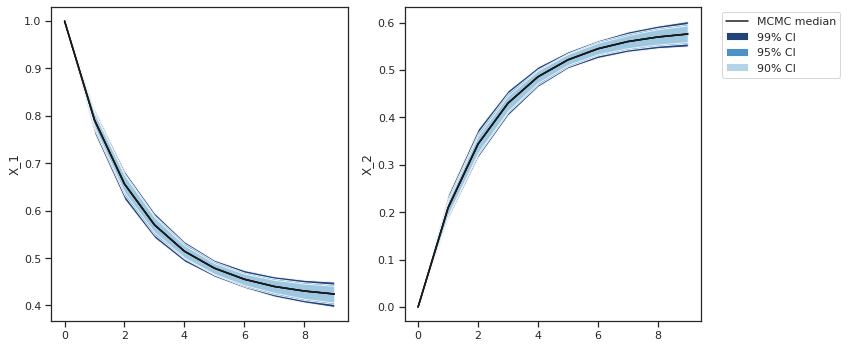

In [9]:
ax = visualize.sampling_prediction_profiles(result, alpha=alpha, 
                                            stepsize=5, size=(10,5))

100%|██████████| 1901/1901 [00:05<00:00, 334.32it/s]


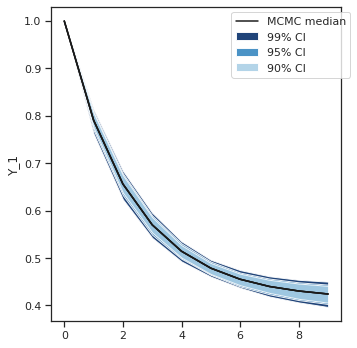

In [10]:
ax = visualize.sampling_prediction_profiles(result, alpha=alpha, plot_type='observables', 
                                            stepsize=5, size=(5,5))

Alternatively, prediction profiles can be plotted by condition. Evaluation of samples can also be parallelized by specifying `n_procs` as the number of processors to use.

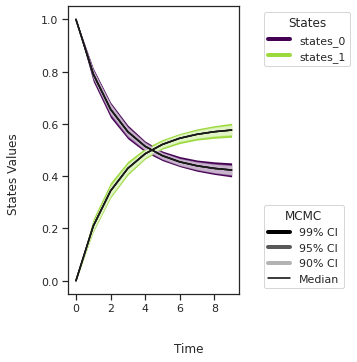

In [11]:
ax = visualize.sampling_prediction_profiles_conditions(
    result,
    ci_levels=alpha,
    plot_type='states',
    step_size=10,
    size=(5,5),
    #y_names=['state_1', 'state_2'],
    n_procs=-1,  # -1 results in all available processors being used
    axis_label_padding=40,
)

If you want to save the prediction confidence intervals and use your own visualization routine:

In [12]:
simulated_observables, simulated_states = sample.evaluate_samples(result=result, stepsize=10)
#simulated_observables, simulated_states = sample.evaluate_samples(result=result, stepsize=10, n_procs=-1)

100%|██████████| 951/951 [00:02<00:00, 370.16it/s]


In [13]:
lb_states, ub_states = sample.calculate_prediction_profiles(simulated_states)
lb_observables, ub_observables = sample.calculate_prediction_profiles(simulated_observables)

The same can be done for the parameter confidence intervals :)

In [14]:
lb, ub = sample.calculate_ci(result=result)

### Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [15]:
res = optimize.minimize(problem, n_starts=10)

By passing the result object to the function, the previously found global optimum is used as starting point for the MCMC sampling.

In [16]:
res = sample.sample(problem, n_samples=10000, sampler=sampler, result=res)
elapsed_time = res.sample_result.time
print('Elapsed time: '+str(round(elapsed_time,2)))

100%|██████████| 10000/10000 [01:18<00:00, 127.05it/s]


Elapsed time: 98.59


When the sampling is finished, we can analyse our results. pyPESTO provides functions to analyse both the sampling process as well as the obtained sampling result. Visualizing the traces e.g. allows to detect burn-in phases, or fine-tune hyperparameters. First, the parameter trajectories  can be visualized:

Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., 'pypesto.sample.geweke_test'.


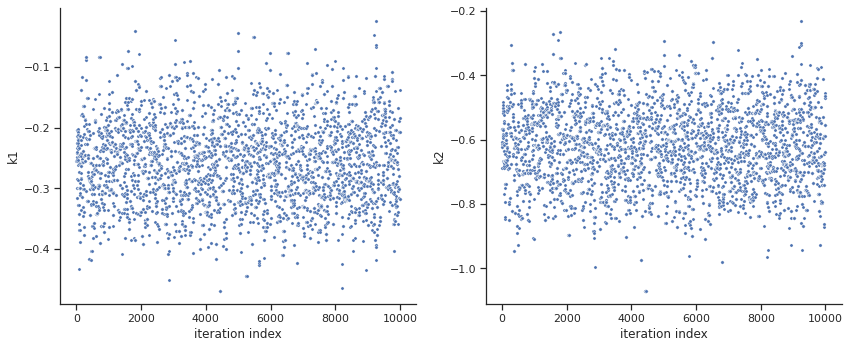

In [17]:
ax = visualize.sampling_parameters_trace(res, use_problem_bounds=False, size=(12,5))

By visual inspection one can see that the chain is already converged from the start. This is already showing the benefit of initiating the chain at the optimal parameter vector. However, this may not be always the case.

Geweke burn-in index: 0


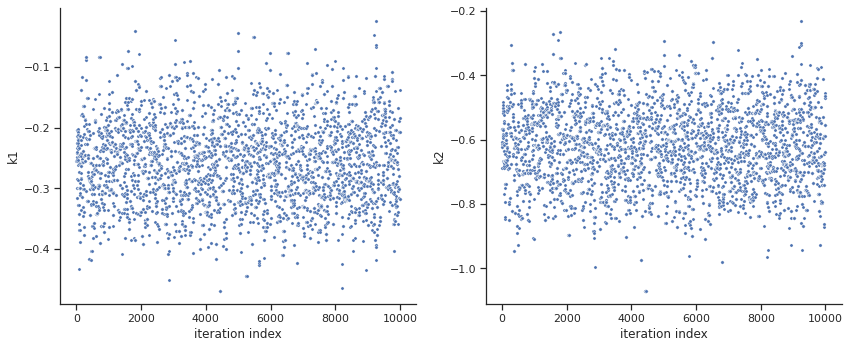

In [18]:
sample.geweke_test(result=res)
ax = visualize.sampling_parameters_trace(res, use_problem_bounds=False, size=(12,5))

In [19]:
sample.effective_sample_size(result=res)
ess = res.sample_result.effective_sample_size
print(f'Effective sample size per computation time: {round(ess/elapsed_time,2)}')

Estimated chain autocorrelation: 9.436409149972901
Estimated effective sample size: 958.2797930096453


Effective sample size per computation time: 9.72


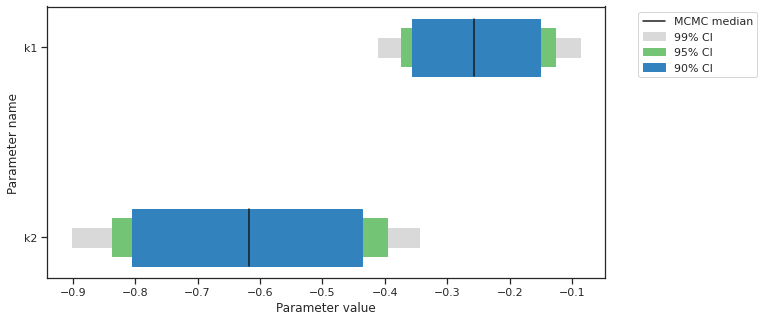

In [20]:
alpha = [99, 95, 90]
ax = visualize.sampling_parameters_cis(res, alpha=alpha, size=(10,5))

100%|██████████| 2001/2001 [00:06<00:00, 311.66it/s]


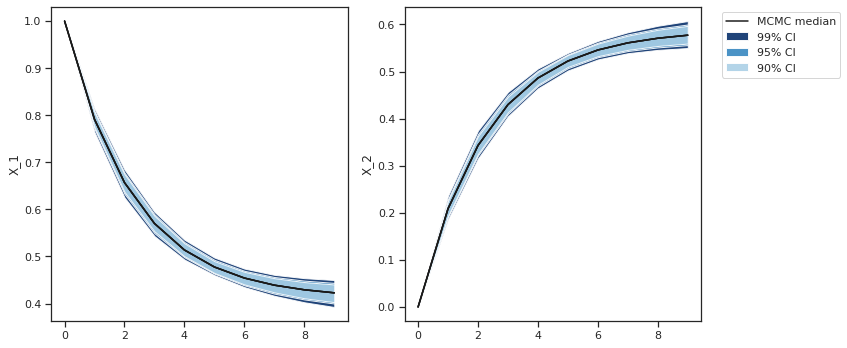

In [21]:
ax = visualize.sampling_prediction_profiles(res, alpha=alpha, 
                                            stepsize=5, size=(10,5))

100%|██████████| 2001/2001 [00:06<00:00, 318.35it/s]


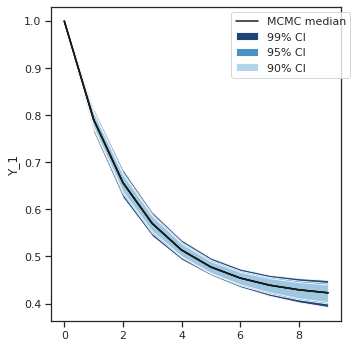

In [22]:
ax = visualize.sampling_prediction_profiles(res, alpha=alpha, plot_type='observables', 
                                            stepsize=5, size=(5,5))